In [1]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
import seaborn as sns # Import seaborn

from datetime import datetime
from datetime import date
from dateutil import parser

from collections import defaultdict

import warnings
import time


In [2]:
# open connection 
conn = sqlite3.connect("data/database.sqlite")
cur = conn.cursor()

In [3]:
# function to execute queries
def executeQuery(cur, query):
    print("executing query: ")
    cur.execute(query)
    return cur.fetchall()

In [4]:
# list of all tables
q_all_tables = """SELECT name FROM sqlite_master
    WHERE type='table';"""
all_tables = executeQuery(cur, q_all_tables)


executing query: 


## Read the dataframe from preprocessing 1

In [5]:
curr_date = "2023-03-13"
pickle_file = 'sa-preprocessing-' + curr_date + '.pkl'
pickle_file_path = 'data/' + pickle_file
df_main_nn = pd.read_pickle(pickle_file_path)

In [6]:
# show all columns
pd.options.display.max_columns = None

In [7]:
# calculate age
pd.options.mode.chained_assignment = None

hp = 'home_player_'
ap = 'away_player_'
for i in range(1, 12):
    hp_n = hp+str(i)
    ap_n = ap+str(i)
    df_main_nn['date'] = pd.to_datetime(df_main_nn['date'])
    df_main_nn[hp_n+"_birthday"] = pd.to_datetime(df_main_nn[hp_n+"_birthday"])
    df_main_nn[ap_n+"_birthday"] = pd.to_datetime(df_main_nn[ap_n+"_birthday"])
    
    df_main_nn[hp_n+"_age"] = (df_main_nn['date'].dt.year - df_main_nn[hp_n+"_birthday"].dt.year)
    df_main_nn[ap_n+"_age"] = (df_main_nn['date'].dt.year - df_main_nn[ap_n+"_birthday"].dt.year)   

In [8]:
print(df_main_nn.shape)

df_main_nn.tail()

(21374, 184)


,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,player_api_id_x,home_player_1_name,home_player_1_birthday,home_player_1_height,home_player_1_weight,player_api_id_y,home_player_2_name,home_player_2_birthday,home_player_2_height,home_player_2_weight,player_api_id_x,home_player_3_name,home_player_3_birthday,home_player_3_height,home_player_3_weight,player_api_id_y,home_player_4_name,home_player_4_birthday,home_player_4_height,home_player_4_weight,player_api_id_x,home_player_5_name,home_player_5_birthday,home_player_5_height,home_player_5_weight,player_api_id_y,home_player_6_name,home_player_6_birthday,home_player_6_height,home_player_6_weight,player_api_id_x,home_player_7_name,home_player_7_birthday,home_player_7_height,home_player_7_weight,player_api_id_y,home_player_8_name,home_player_8_birthday,home_player_8_height,home_player_8_weight,player_api_id_x,home_player_9_name,home_player_9_birthday,home_player_9_height,home_player_9_weight,player_api_id_y,home_player_10_name,home_player_10_birthday,home_player_10_height,home_player_10_weight,player_api_id_x,home_player_11_name,home_player_11_birthday,home_player_11_height,home_player_11_weight,player_api_id_y,away_player_1_name,away_player_1_birthday,away_player_1_height,away_player_1_weight,player_api_id_x,away_player_2_name,away_player_2_birthday,away_player_2_height,away_player_2_weight,player_api_id_y,away_player_3_name,away_player_3_birthday,away_player_3_height,away_player_3_weight,player_api_id_x,away_player_4_name,away_player_4_birthday,away_player_4_height,away_player_4_weight,player_api_id_y,away_player_5_name,away_player_5_birthday,away_player_5_height,away_player_5_weight,player_api_id_x,away_player_6_name,away_player_6_birthday,away_player_6_height,away_player_6_weight,player_api_id_y,away_player_7_name,away_player_7_birthday,away_player_7_height,away_player_7_weight,player_api_id_x,away_player_8_name,away_player_8_birthday,away_player_8_height,away_player_8_weight,player_api_id_y,away_player_9_name,away_player_9_birthday,away_player_9_height,away_player_9_weight,player_api_id_x,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,player_api_id_y,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight,home_player_1_rating,away_player_1_rating,home_player_2_rating,away_player_2_rating,home_player_3_rating,away_player_3_rating,home_player_4_rating,away_player_4_rating,home_player_5_rating,away_player_5_rating,home_player_6_rating,away_player_6_rating,home_player_7_rating,away_player_7_rating,home_player_8_rating,away_player_8_rating,home_player_9_rating,away_player_9_rating,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_player_1_age,away_player_1_age,home_player_2_age,away_player_2_age,home_player_3_age,away_player_3_age,home_player_4_age,away_player_4_age,home_player_5_age,away_player_5_age,home_player_6_age,away_player_6_age,home_player_7_age,away_player_7_age,home_player_8_age,away_player_8_age,home_player_9_age,away_player_9_age,home_player_10_age,away_player_10_age,home_player_11_age,away_player_11_age
21369,25905,2015/2016,2016-04-20,1992191,9931,7896,3,0,156175.0,458806.0,22834.0,30492.0,181211.0,438780.0,207234.0,384376.0,34035.0,25794.0,527103.0,330458.0,282287.0,173534.0,41415.0,114212.0,491221.0,393337.0,8893.0,406283.0,614454.0,186948.0,156175,Tomas Vaclik,1989-03-29,187.96,187,458806,Naser Aliji,1993-12-27,177.80,161,22834,Marek Suchy,1988-03-29,182.88,168,30492,Walter Samuel,1978-03-23,182.88,179,181211,Adama Traore,1990-02-03,170.18,161,438780,Alexander Fransson,1994-04-02,180.34,163,207234,

In [9]:
df_main_nn['outcome'] = (df_main_nn["home_team_goal"] > df_main_nn["away_team_goal"])

In [10]:
df_main_nn = df_main_nn.sort_values(['home_team_api_id', 'date'])

In [11]:
df_main_nn['last_ten'] = False

In [12]:
# df_main_clean['last_ten'] = df_main_clean.groupby('home_team_api_id')['outcome'].rolling(window=10, min_periods=1).sum().reset_index(level=0, drop=True)
# df_main_clean['last_ten'] = df_main_clean.groupby(['date', 'home_team_api_id'])['outcome'].rolling(window=10, min_periods=1).sum().shift(1)
df_main_nn['last_ten'] = df_main_nn.groupby('home_team_api_id')['outcome'].rolling(window=30, min_periods=1, closed="left").sum().reset_index(0, drop=True)
df_main_nn = df_main_nn[~df_main_nn.isnull().any(axis=1)]

In [13]:
# Proof of Concept for rolling window of 10 
df = pd.DataFrame({
    'team_id': ['A', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'B', 'A', 'A', 'B'],
    'game_date': pd.date_range(start='2022-01-01', periods=20, freq='D'),
    'game_result': [True, False, True, True, True, False, True, True, False, True, True, False, True, False, True, False, True, True, True, False]
})

# Compute the number of wins in the last 10 games for each team
# df['last_ten'] = df.groupby('team_id')['game_result'].rolling(window=10, min_periods=2).sum().reset_index(0, drop=True)
df = df.sort_values(['team_id', 'game_date'])
df['last_ten'] = df.groupby(['team_id'])['game_result'].rolling(window=15, min_periods=5, closed="left").sum().reset_index(0, drop=True)


In [14]:
print(df_main_nn.shape)
export_list = ['id_main', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'outcome', 'last_ten']
df_main_streak = df_main_nn[export_list]
df_2_csv = df_main_streak.tail(400).to_csv('data/last_ten.csv')

(20757, 186)


In [15]:
df_main_nn.head()

,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,player_api_id_x,home_player_1_name,home_player_1_birthday,home_player_1_height,home_player_1_weight,player_api_id_y,home_player_2_name,home_player_2_birthday,home_player_2_height,home_player_2_weight,player_api_id_x,home_player_3_name,home_player_3_birthday,home_player_3_height,home_player_3_weight,player_api_id_y,home_player_4_name,home_player_4_birthday,home_player_4_height,home_player_4_weight,player_api_id_x,home_player_5_name,home_player_5_birthday,home_player_5_height,home_player_5_weight,player_api_id_y,home_player_6_name,home_player_6_birthday,home_player_6_height,home_player_6_weight,player_api_id_x,home_player_7_name,home_player_7_birthday,home_player_7_height,home_player_7_weight,player_api_id_y,home_player_8_name,home_player_8_birthday,home_player_8_height,home_player_8_weight,player_api_id_x,home_player_9_name,home_player_9_birthday,home_player_9_height,home_player_9_weight,player_api_id_y,home_player_10_name,home_player_10_birthday,home_player_10_height,home_player_10_weight,player_api_id_x,home_player_11_name,home_player_11_birthday,home_player_11_height,home_player_11_weight,player_api_id_y,away_player_1_name,away_player_1_birthday,away_player_1_height,away_player_1_weight,player_api_id_x,away_player_2_name,away_player_2_birthday,away_player_2_height,away_player_2_weight,player_api_id_y,away_player_3_name,away_player_3_birthday,away_player_3_height,away_player_3_weight,player_api_id_x,away_player_4_name,away_player_4_birthday,away_player_4_height,away_player_4_weight,player_api_id_y,away_player_5_name,away_player_5_birthday,away_player_5_height,away_player_5_weight,player_api_id_x,away_player_6_name,away_player_6_birthday,away_player_6_height,away_player_6_weight,player_api_id_y,away_player_7_name,away_player_7_birthday,away_player_7_height,away_player_7_weight,player_api_id_x,away_player_8_name,away_player_8_birthday,away_player_8_height,away_player_8_weight,player_api_id_y,away_player_9_name,away_player_9_birthday,away_player_9_height,away_player_9_weight,player_api_id_x,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,player_api_id_y,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight,home_player_1_rating,away_player_1_rating,home_player_2_rating,away_player_2_rating,home_player_3_rating,away_player_3_rating,home_player_4_rating,away_player_4_rating,home_player_5_rating,away_player_5_rating,home_player_6_rating,away_player_6_rating,home_player_7_rating,away_player_7_rating,home_player_8_rating,away_player_8_rating,home_player_9_rating,away_player_9_rating,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_player_1_age,away_player_1_age,home_player_2_age,away_player_2_age,home_player_3_age,away_player_3_age,home_player_4_age,away_player_4_age,home_player_5_age,away_player_5_age,home_player_6_age,away_player_6_age,home_player_7_age,away_player_7_age,home_player_8_age,away_player_8_age,home_player_9_age,away_player_9_age,home_player_10_age,away_player_10_age,home_player_11_age,away_player_11_age,outcome,last_ten
21338,17015,2013/2014,2013-07-26,1467699,1601,8030,1,1,275751.0,178702.0,69254.0,69619.0,282168.0,68786.0,13405.0,30278.0,287341.0,68802.0,178196.0,69004.0,210978.0,69553.0,190010.0,13474.0,406505.0,69043.0,402419.0,30526.0,69061.0,443987.0,275751,Krzysztof Kaminski,1990-11-26,190.5,179,178702,Artur Gieraga,1988-05-04,182.88,176,69254,Marek Szyndrowski,1980-10-30,182.88,165,69619,Piotr Stawarczyk,1983-09-29,193.04,192,282168,Daniel Dziwniel,1992-08-19,177.8,159,68786,Bartlomiej Babiarz,

In [16]:
# Average Height for teams

hp = 'home_player_'
hp_col_list_height = [hp+str(i)+'_height' for i in range(1,12)] 

ap = 'away_player_'
ap_col_list_height = [ap+str(i)+'_height' for i in range(1,12)] 
  

df_main_nn[hp+'height_total'] = df_main_nn[hp_col_list_height].sum(axis=1)
df_main_nn[ap+'height_total'] = df_main_nn[ap_col_list_height].sum(axis=1)



In [17]:
# Average Weight for teams

hp = 'home_player_'
hp_col_list_weight = [hp+str(i)+'_weight' for i in range(1,12)] 
hp_col_list_age = [hp+str(i)+'_age' for i in range(1,12)]
hp_col_list_rating = [hp+str(i)+'_rating' for i in range(1,12)] 
# print(hp_col_list_weight)    

ap = 'away_player_'
ap_col_list_weight = [ap+str(i)+'_weight' for i in range(1,12)]
ap_col_list_age = [ap+str(i)+'_age' for i in range(1,12)]
ap_col_list_rating = [hp+str(i)+'_rating' for i in range(1,12)] 
# print(ap_col_list_weight)

df_main_nn[hp+'weight_total'] = df_main_nn[hp_col_list_weight].sum(axis=1)
df_main_nn[ap+'weight_total'] = df_main_nn[ap_col_list_weight].sum(axis=1)

df_main_nn[hp+'rating_total'] = df_main_nn[hp_col_list_rating].sum(axis=1)
df_main_nn[ap+'rating_total'] = df_main_nn[ap_col_list_rating].sum(axis=1)

df_main_nn[hp+'age_total'] = df_main_nn[hp_col_list_age].sum(axis=1)
df_main_nn[ap+'age_total'] = df_main_nn[ap_col_list_age].sum(axis=1)

df_main_nn[hp+'age_average'] = (df_main_nn[hp+'age_total']/11)
df_main_nn[ap+'age_average'] = (df_main_nn[ap+'age_total']/11)

df_main_nn[hp+'rating_average'] = (df_main_nn[hp+'rating_total']/11)
df_main_nn[ap+'rating_average'] = (df_main_nn[ap+'rating_total']/11)


In [18]:
# calculate BMI for teams 
df_main_nn['home_team_bmi'] = ((df_main_nn['home_player_weight_total']/2.20462)/((df_main_nn['home_player_height_total']/100)**2))*11
df_main_nn['away_team_bmi'] = ((df_main_nn['away_player_weight_total']/2.20462)/((df_main_nn['away_player_height_total']/100)**2))*11

In [19]:
df_main_nn.tail()

,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,player_api_id_x,home_player_1_name,home_player_1_birthday,home_player_1_height,home_player_1_weight,player_api_id_y,home_player_2_name,home_player_2_birthday,home_player_2_height,home_player_2_weight,player_api_id_x,home_player_3_name,home_player_3_birthday,home_player_3_height,home_player_3_weight,player_api_id_y,home_player_4_name,home_player_4_birthday,home_player_4_height,home_player_4_weight,player_api_id_x,home_player_5_name,home_player_5_birthday,home_player_5_height,home_player_5_weight,player_api_id_y,home_player_6_name,home_player_6_birthday,home_player_6_height,home_player_6_weight,player_api_id_x,home_player_7_name,home_player_7_birthday,home_player_7_height,home_player_7_weight,player_api_id_y,home_player_8_name,home_player_8_birthday,home_player_8_height,home_player_8_weight,player_api_id_x,home_player_9_name,home_player_9_birthday,home_player_9_height,home_player_9_weight,player_api_id_y,home_player_10_name,home_player_10_birthday,home_player_10_height,home_player_10_weight,player_api_id_x,home_player_11_name,home_player_11_birthday,home_player_11_height,home_player_11_weight,player_api_id_y,away_player_1_name,away_player_1_birthday,away_player_1_height,away_player_1_weight,player_api_id_x,away_player_2_name,away_player_2_birthday,away_player_2_height,away_player_2_weight,player_api_id_y,away_player_3_name,away_player_3_birthday,away_player_3_height,away_player_3_weight,player_api_id_x,away_player_4_name,away_player_4_birthday,away_player_4_height,away_player_4_weight,player_api_id_y,away_player_5_name,away_player_5_birthday,away_player_5_height,away_player_5_weight,player_api_id_x,away_player_6_name,away_player_6_birthday,away_player_6_height,away_player_6_weight,player_api_id_y,away_player_7_name,away_player_7_birthday,away_player_7_height,away_player_7_weight,player_api_id_x,away_player_8_name,away_player_8_birthday,away_player_8_height,away_player_8_weight,player_api_id_y,away_player_9_name,away_player_9_birthday,away_player_9_height,away_player_9_weight,player_api_id_x,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,player_api_id_y,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight,home_player_1_rating,away_player_1_rating,home_player_2_rating,away_player_2_rating,home_player_3_rating,away_player_3_rating,home_player_4_rating,away_player_4_rating,home_player_5_rating,away_player_5_rating,home_player_6_rating,away_player_6_rating,home_player_7_rating,away_player_7_rating,home_player_8_rating,away_player_8_rating,home_player_9_rating,away_player_9_rating,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_player_1_age,away_player_1_age,home_player_2_age,away_player_2_age,home_player_3_age,away_player_3_age,home_player_4_age,away_player_4_age,home_player_5_age,away_player_5_age,home_player_6_age,away_player_6_age,home_player_7_age,away_player_7_age,home_player_8_age,away_player_8_age,home_player_9_age,away_player_9_age,home_player_10_age,away_player_10_age,home_player_11_age,away_player_11_age,outcome,last_ten,home_player_height_total,away_player_height_total,home_player_weight_total,away_player_weight_total,home_player_rating_total,away_player_rating_total,home_player_age_total,away_player_age_total,home_player_age_average,away_player_age_average,home_player_rating_average,away_player_rating_average,home_team_bmi,away_team_bmi
2869,1589,2015/2016,2015-12-19,1979980,274581,8475,0,1,128083.0,280251.0,202471.0,210138.0,364826.0,293003.0,277335.0,447455.0,387723.0,213487.0,442735.0,305248.0,2919

In [20]:
df_main_nn.tail()

,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,player_api_id_x,home_player_1_name,home_player_1_birthday,home_player_1_height,home_player_1_weight,player_api_id_y,home_player_2_name,home_player_2_birthday,home_player_2_height,home_player_2_weight,player_api_id_x,home_player_3_name,home_player_3_birthday,home_player_3_height,home_player_3_weight,player_api_id_y,home_player_4_name,home_player_4_birthday,home_player_4_height,home_player_4_weight,player_api_id_x,home_player_5_name,home_player_5_birthday,home_player_5_height,home_player_5_weight,player_api_id_y,home_player_6_name,home_player_6_birthday,home_player_6_height,home_player_6_weight,player_api_id_x,home_player_7_name,home_player_7_birthday,home_player_7_height,home_player_7_weight,player_api_id_y,home_player_8_name,home_player_8_birthday,home_player_8_height,home_player_8_weight,player_api_id_x,home_player_9_name,home_player_9_birthday,home_player_9_height,home_player_9_weight,player_api_id_y,home_player_10_name,home_player_10_birthday,home_player_10_height,home_player_10_weight,player_api_id_x,home_player_11_name,home_player_11_birthday,home_player_11_height,home_player_11_weight,player_api_id_y,away_player_1_name,away_player_1_birthday,away_player_1_height,away_player_1_weight,player_api_id_x,away_player_2_name,away_player_2_birthday,away_player_2_height,away_player_2_weight,player_api_id_y,away_player_3_name,away_player_3_birthday,away_player_3_height,away_player_3_weight,player_api_id_x,away_player_4_name,away_player_4_birthday,away_player_4_height,away_player_4_weight,player_api_id_y,away_player_5_name,away_player_5_birthday,away_player_5_height,away_player_5_weight,player_api_id_x,away_player_6_name,away_player_6_birthday,away_player_6_height,away_player_6_weight,player_api_id_y,away_player_7_name,away_player_7_birthday,away_player_7_height,away_player_7_weight,player_api_id_x,away_player_8_name,away_player_8_birthday,away_player_8_height,away_player_8_weight,player_api_id_y,away_player_9_name,away_player_9_birthday,away_player_9_height,away_player_9_weight,player_api_id_x,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,player_api_id_y,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight,home_player_1_rating,away_player_1_rating,home_player_2_rating,away_player_2_rating,home_player_3_rating,away_player_3_rating,home_player_4_rating,away_player_4_rating,home_player_5_rating,away_player_5_rating,home_player_6_rating,away_player_6_rating,home_player_7_rating,away_player_7_rating,home_player_8_rating,away_player_8_rating,home_player_9_rating,away_player_9_rating,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_player_1_age,away_player_1_age,home_player_2_age,away_player_2_age,home_player_3_age,away_player_3_age,home_player_4_age,away_player_4_age,home_player_5_age,away_player_5_age,home_player_6_age,away_player_6_age,home_player_7_age,away_player_7_age,home_player_8_age,away_player_8_age,home_player_9_age,away_player_9_age,home_player_10_age,away_player_10_age,home_player_11_age,away_player_11_age,outcome,last_ten,home_player_height_total,away_player_height_total,home_player_weight_total,away_player_weight_total,home_player_rating_total,away_player_rating_total,home_player_age_total,away_player_age_total,home_player_age_average,away_player_age_average,home_player_rating_average,away_player_rating_average,home_team_bmi,away_team_bmi
2869,1589,2015/2016,2015-12-19,1979980,274581,8475,0,1,128083.0,280251.0,202471.0,210138.0,364826.0,293003.0,277335.0,447455.0,387723.0,213487.0,442735.0,305248.0,2919

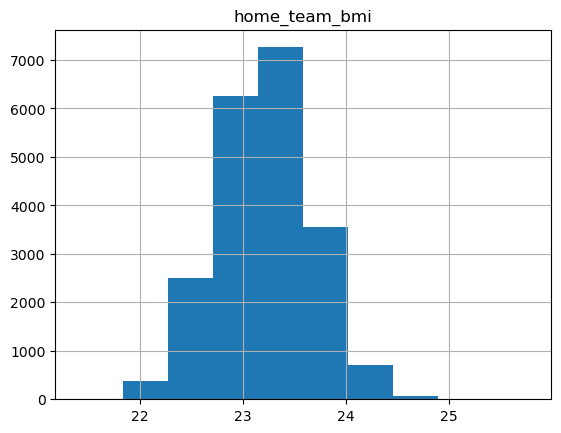

In [21]:
hist_home_team_bmi = df_main_nn.hist(column='home_team_bmi', bins=10)

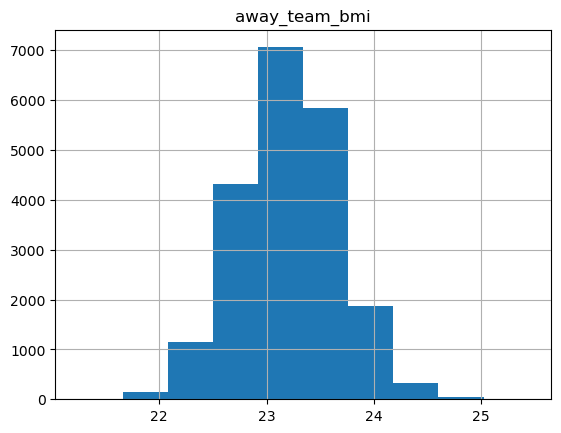

In [22]:
hist_away_team_bmi = df_main_nn.hist(column='away_team_bmi', bins=10)

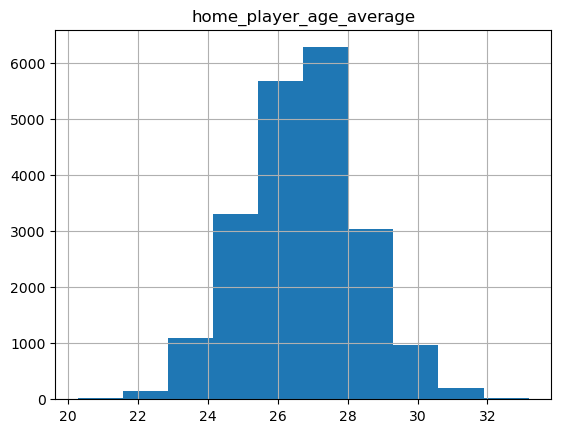

In [23]:
hist_home_player_age_average = df_main_nn.hist(column='home_player_age_average', bins=10)

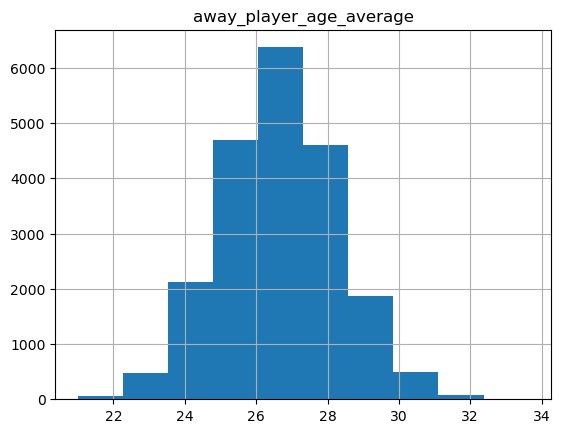

In [24]:
hist_away_player_age_average = df_main_nn.hist(column='away_player_age_average', bins=10)

In [25]:
count_home_team_win = df_main_nn['outcome'].value_counts()[True]
count_home_team_not_win = df_main_nn['outcome'].value_counts()[False]
game_sum = count_home_team_win + count_home_team_not_win 
print("Home team win count")
print(count_home_team_win)
print("\nHome team no win count")
print(count_home_team_not_win)
print("\nActual win percentage for home team")
print((count_home_team_win / game_sum )* 100)

Home team win count
9542

Home team no win count
11215

Actual win percentage for home team
45.970034205328325


In [26]:
# Create the dataframe for modeling
X = df_main_nn[["home_team_bmi", "away_team_bmi", "home_player_age_average", "away_player_age_average", "home_player_rating_average", "away_player_rating_average", "last_ten"]].values
y = df_main_nn['outcome'].values

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [27]:
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

print(decision_tree.score(X_test, y_test))
print(random_forest.score(X_test, y_test))


0.5364161849710982
0.5909441233140655


In [28]:
# always run this at connecting
conn.close()